# <br> HDBSCAN Clustering analysis performed for hotels' data coming from Bidroom DB + UMAP as dimentionality reducer

### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 


In [217]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [218]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn import metrics
import umap
import hdbscan
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from DBCV.DBCV import DBCV

pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', True)


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [219]:
file = pd.read_csv("Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


#### <br> This analysis is provided for characteristics without the room_types that is why I am removing from original file thwo columns: room_type_no and room_type_en  <br>

In [220]:
fileWorking = fileWorking.drop(columns=["room_type_no","room_type_en"])

### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [221]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,amenity
0,5622,1174,4,GB,GBP,51.521259,-0.155856,3.12,34,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
1,5630,1174,3,GB,GBP,51.512071,-0.185206,4.30,45,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /..."
2,5640,1174,4,GB,GBP,51.507706,-0.147138,1.67,106,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room..."
3,5671,1174,4,GB,GBP,51.490098,-0.138130,1.39,72,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
4,5681,1174,5,GB,GBP,51.496872,-0.167604,2.89,28,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly..."


#### I used the one-hot-encoding for hotel_type - separate column was created for each hotel_type and as a value was 1 if the hotel was that type and 0 otherwise

In [222]:
def hotel_type_to_columns(df):
    hotel_type_dict = {
        1:"1-star_Hotel",
        2:"2-star_Hotel",
        3:"3-star_Hotel",
        4:"4-star_Hotel",
        5:"5-star_Hotel",
        8:"Apartment_Hotel_Type",
        9:"Hostel",
        10:"Motel",
        11:"Inn",
        12:"Bed&Breakfast",
        13:"Vacation_Rental",
        15:"Resort",
        16:"Other",
        23:"Aparthotel",
        25:"Boutique_Hotel",
        30:"Guesthouse",
        32:"Camping",
        33:"Villa",
        34:"Farm_Stay",
        36:"Hotel"
    }   
    df["hotel_type_en"] = df.hotel_type.map(hotel_type_dict)
    df = pd.get_dummies(df, prefix=["ht"], columns=['hotel_type_en'])
    
    df.columns = df.columns.str.lower()
    return df

In [223]:
fileWorking = hotel_type_to_columns(fileWorking)

In [224]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 1040 non-null   int64  
 1   hotel_city               1040 non-null   int64  
 2   hotel_type               1040 non-null   int64  
 3   hotel_country            1040 non-null   object 
 4   hotel_currency_code      1040 non-null   object 
 5   hotel_lat                1040 non-null   float64
 6   hotel_lon                1040 non-null   float64
 7   hotel_distance           881 non-null    float64
 8   rooms_count              1040 non-null   int64  
 9   label                    0 non-null      float64
 10  amenity                  1038 non-null   object 
 11  ht_1-star_hotel          1040 non-null   uint8  
 12  ht_2-star_hotel          1040 non-null   uint8  
 13  ht_3-star_hotel          1040 non-null   uint8  
 14  ht_4-star_hotel         

#### <br> Amenities column contains a list of amenities for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

#### <br> First I removed two rows that didn't have any amenities and label column that did not have any data <br>

In [225]:
fileWorking.loc[pd.isna(fileWorking["amenity"]), :].index

Int64Index([109, 111], dtype='int64')

In [226]:
fileWorking = fileWorking.drop([fileWorking.index[109], fileWorking.index[111]])

In [227]:
fileWorking = fileWorking.drop(columns=["label"])

In [228]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1039
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 1038 non-null   int64  
 1   hotel_city               1038 non-null   int64  
 2   hotel_type               1038 non-null   int64  
 3   hotel_country            1038 non-null   object 
 4   hotel_currency_code      1038 non-null   object 
 5   hotel_lat                1038 non-null   float64
 6   hotel_lon                1038 non-null   float64
 7   hotel_distance           879 non-null    float64
 8   rooms_count              1038 non-null   int64  
 9   amenity                  1038 non-null   object 
 10  ht_1-star_hotel          1038 non-null   uint8  
 11  ht_2-star_hotel          1038 non-null   uint8  
 12  ht_3-star_hotel          1038 non-null   uint8  
 13  ht_4-star_hotel          1038 non-null   uint8  
 14  ht_5-star_hotel         

### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [229]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 648 non-null    int64  
 1   hotel_city               648 non-null    int64  
 2   hotel_type               648 non-null    int64  
 3   hotel_country            648 non-null    object 
 4   hotel_currency_code      648 non-null    object 
 5   hotel_lat                648 non-null    float64
 6   hotel_lon                648 non-null    float64
 7   hotel_distance           636 non-null    float64
 8   rooms_count              648 non-null    int64  
 9   amenity                  648 non-null    object 
 10  ht_1-star_hotel          648 non-null    uint8  
 11  ht_2-star_hotel          648 non-null    uint8  
 12  ht_3-star_hotel          648 non-null    uint8  
 13  ht_4-star_hotel          648 non-null    uint8  
 14  ht_5-star_hotel          

#### Creating working file for London in Great Britain

In [230]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 1039
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hotel_id                 390 non-null    int64  
 1   hotel_city               390 non-null    int64  
 2   hotel_type               390 non-null    int64  
 3   hotel_country            390 non-null    object 
 4   hotel_currency_code      390 non-null    object 
 5   hotel_lat                390 non-null    float64
 6   hotel_lon                390 non-null    float64
 7   hotel_distance           243 non-null    float64
 8   rooms_count              390 non-null    int64  
 9   amenity                  390 non-null    object 
 10  ht_1-star_hotel          390 non-null    uint8  
 11  ht_2-star_hotel          390 non-null    uint8  
 12  ht_3-star_hotel          390 non-null    uint8  
 13  ht_4-star_hotel          390 non-null    uint8  
 14  ht_5-star_hotel          

In [231]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))
    for x in amenities:
        if x != x:
            continue
        else:
            com = '(.*)?('+ x +')(.*)?'
            df[x]=[1 if re.search(com,str(a)) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df

amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Creating final dataset for clustering analysis

In [232]:
# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

In [233]:
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 389
Data columns (total 63 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    390 non-null    int64  
 1   hotel_city                  390 non-null    int64  
 2   hotel_type                  390 non-null    int64  
 3   hotel_country               390 non-null    object 
 4   hotel_currency_code         390 non-null    object 
 5   hotel_lat                   390 non-null    float64
 6   hotel_lon                   390 non-null    float64
 7   hotel_distance              243 non-null    float64
 8   rooms_count                 390 non-null    int64  
 9   ht_1-star_hotel             390 non-null    uint8  
 10  ht_2-star_hotel             390 non-null    uint8  
 11  ht_3-star_hotel             390 non-null    uint8  
 12  ht_4-star_hotel             390 non-null    uint8  
 13  ht_5-star_hotel             390 non

## Data Cleaning

### Removing duplicates

In [234]:
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

#### handling information for hotel_currency_code

In [235]:
filesWorkingIDCleaned["hotel_currency_code"].isna().sum()

0

In [236]:
filesWorkingIDCleaned["hotel_currency_code"].unique()

array(['IDR', 'USD', 'EUR'], dtype=object)

In [237]:
# for Jakarta
filesWorkingIDCleaned = pd.get_dummies(filesWorkingIDCleaned,prefix=["curr"], columns=["hotel_currency_code"])
# # for London
filesWorkingGBCleaned = pd.get_dummies(filesWorkingGBCleaned,prefix=["curr"], columns=["hotel_currency_code"])

#### handling information for hotel_country

In [238]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["hotel_country", "hotel_city"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["hotel_country", "hotel_city"])

#### handling information for hotel_distance 

In [239]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
4.16      7
         ..
12.00     1
3.33      1
8.51      1
6.91      1
2.43      1
Name: hotel_distance, Length: 383, dtype: int64

In [240]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
1.60      3
4.03      3
2.39      3
       ... 
4.15      1
1.88      1
2.68      1
3.29      1
1.32      1
Name: hotel_distance, Length: 201, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [241]:
mean1  = filesWorkingIDCleaned["hotel_distance"].mean()
mean2  = filesWorkingGBCleaned["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

#### dropping columns that have only one value and it is 0 

In [181]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["ht_5-star_hotel", "ht_aparthotel", "ht_1-star_hotel", "ht_boutique_hotel"])

#### dropping hotel_id for all data sets

In [182]:
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id"])

### Visualize heatmap for all hotels characteristics in Jakarta

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in Jakarta')

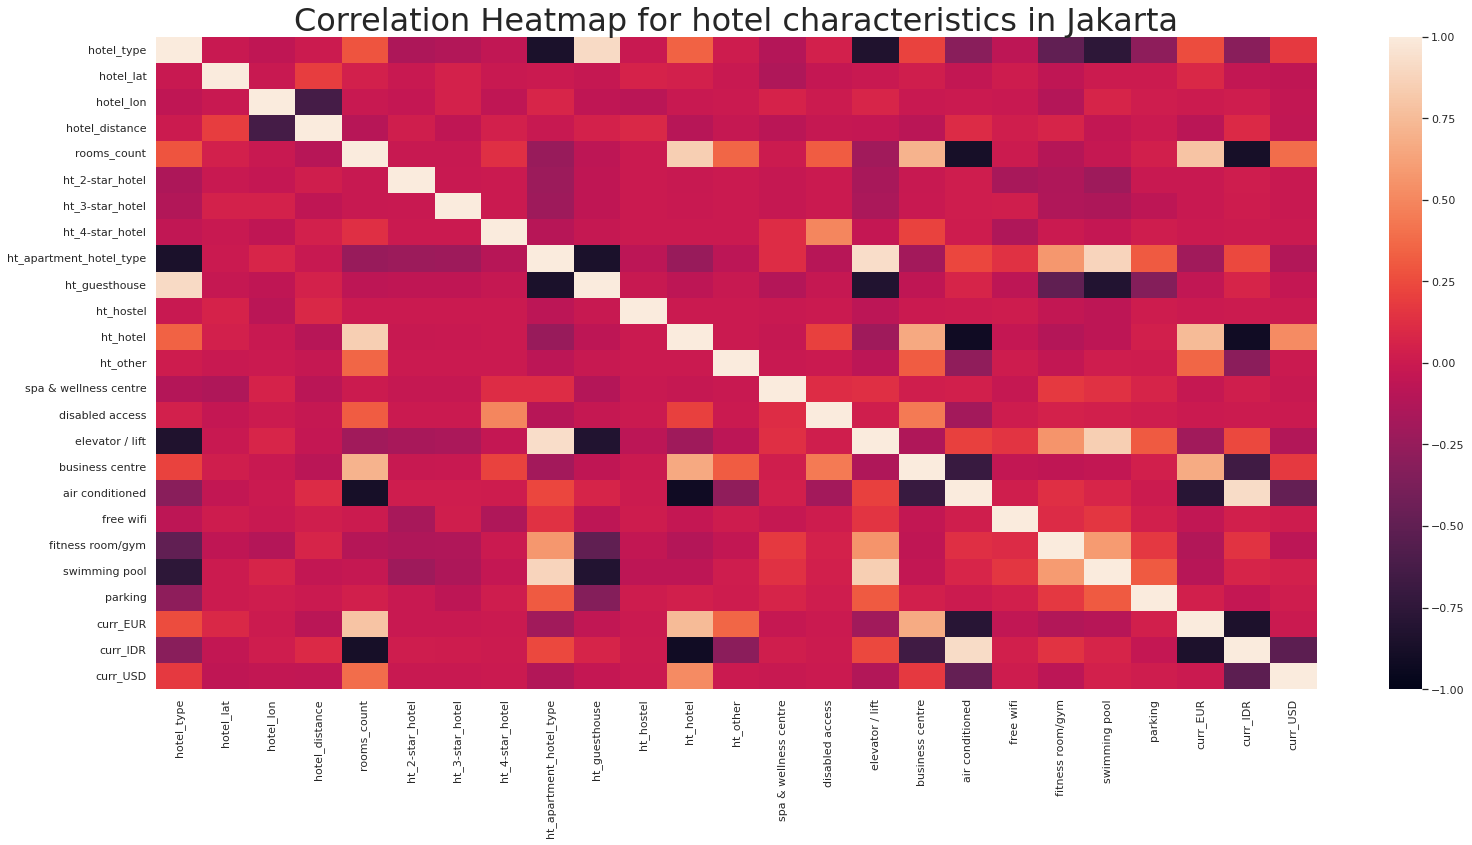

In [183]:

plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 36})
heatmap = sns.heatmap(indonesia.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in Jakarta", fontdict={"fontsize":32})

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in London')

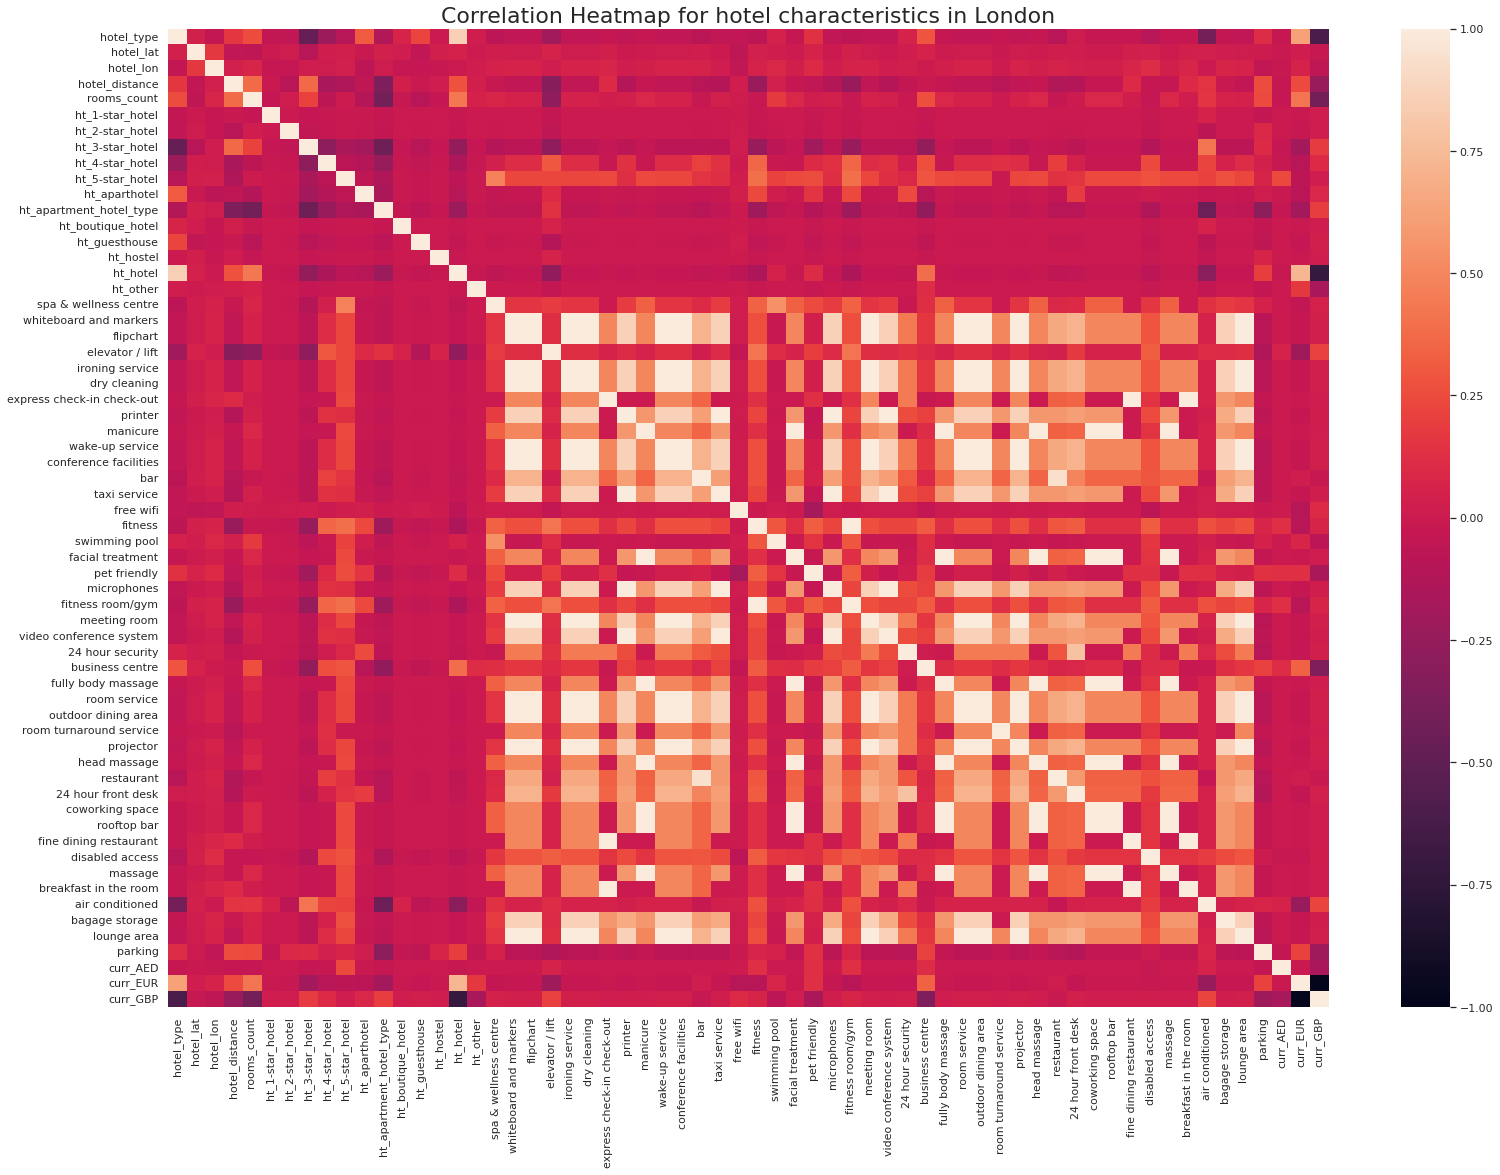

In [184]:

plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(gb.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in London", fontdict={"fontsize":22})

### <br> Concusions: 
#### this time I showed the correlaton between amenities separately for each city:
#### - both cities shows different amount of amenities available in given hotels;
#### - most of amenities are highly correlated for London, so they are showing the same segment of characteristics;
#### - the same pairs of amenities showed slightly different level of correlation for Jakarta and London but the trend was similar for both cities<br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [185]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [186]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning:

divide by zero encountered in double_scalars

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



#### <br> Removing from the working file variables which are highly correlated <br>

In [187]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [188]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])

In [189]:
#### ploting correlation heatmap for final hotel characteristics

(648, 13)

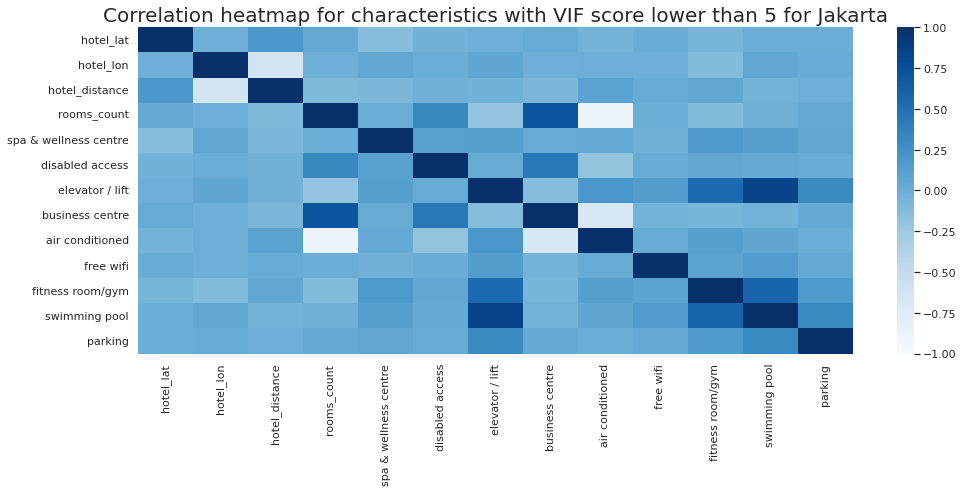

In [190]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(390, 13)

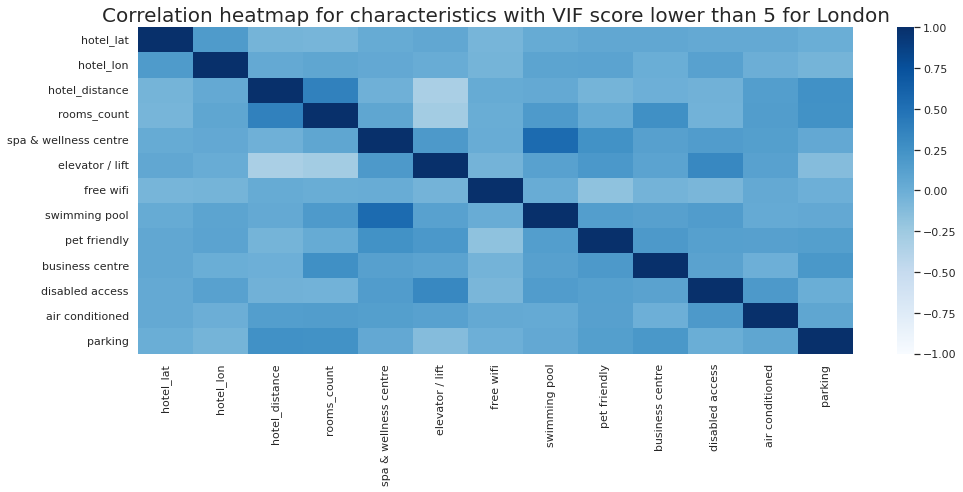

In [191]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

### <br> Conclusions:
#### - this time  function detecting multcolinearity was removing characteristics VIF score higher that 5 what was recomended by documantation, it reduced the dimentions to 9 for Jakarta, 14 for London and 11 for cumulative dataset.
#### - such restrict removing  <br>


## <br>Standarizing data
#### <br> to standarize the data was used Standard Scaler provided by sklear library<br>

In [192]:
scaler = StandardScaler()
# standarizing data from Jakarta
indo_std = scaler.fit_transform(idReducedAnalysis)
# standarizing data from London
gb_std = scaler.fit_transform(gbReducedAnalysis)

## <br> Removing Dimentions with umap algorythm

####  <br> This time I used UMAP to reduce dimentionality of the provided data. UMAP is a general purpose manifold learning and dimension reduction algorithm. Can be used as an effective preprocessing step to boost the performance of density based clustering. <br>

In [193]:
clusterable_embedding_indo = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(indo_std)

clusterable_embedding_indo

array([[13.464391 , -6.820889 ],
       [20.050097 ,  4.812988 ],
       [ 7.241304 ,  1.2818859],
       ...,
       [13.338256 , -7.305331 ],
       [13.343105 , -7.298711 ],
       [13.3367405, -7.3070827]], dtype=float32)

In [194]:
indonesia_train_umap_df = pd.DataFrame(data=np.c_[clusterable_embedding_indo], columns = ["umap_1", "umap_2"])
indonesia_train_umap_df

,umap_1,umap_2
0,13.464391,-6.820889
1,20.050097,4.812988
2,7.241304,1.281886
3,20.432907,11.351249
4,0.409674,-0.974200
...,...,...
643,13.158555,-7.504176
644,13.334646,-7.307963
645,13.338256,-7.305331
646,13.343105,-7.298711


In [195]:
clusterable_embedding_gb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(gb_std)
clusterable_embedding_gb

array([[ 5.91326571e+00, -3.41765070e+00],
       [-5.45465422e+00,  4.89554691e+00],
       [-1.15454924e+00,  1.50719519e+01],
       [ 5.86483717e+00, -3.59831166e+00],
       [-1.18630087e+00,  1.51031427e+01],
       [-5.79445541e-01,  5.07176208e+00],
       [-3.56866288e+00,  1.23103180e+01],
       [ 9.72465992e+00,  4.18538809e+00],
       [-1.83507633e+00,  1.56257629e+01],
       [-1.86090064e+00,  1.56119165e+01],
       [ 2.43161607e+00,  4.47036028e+00],
       [ 9.71626854e+00,  4.19240284e+00],
       [-1.25180554e+00,  1.51494083e+01],
       [-1.20654309e+00,  1.39375019e+01],
       [-3.97852659e+00,  6.10025835e+00],
       [-1.18498346e-02,  1.46728172e+01],
       [ 2.77717412e-01,  1.50341349e+01],
       [-5.35868454e+00,  4.98457527e+00],
       [ 2.99606538e+00,  5.65046597e+00],
       [ 1.54408976e-01,  1.50856695e+01],
       [-1.74254930e+00,  1.56521368e+01],
       [-1.78674328e+00,  1.56152449e+01],
       [ 2.67025185e+00,  4.27478409e+00],
       [ 5.

In [196]:
gb_train_umap_df = pd.DataFrame(data=np.c_[clusterable_embedding_gb], columns = ["umap_1", "umap_2"])
gb_train_umap_df

,umap_1,umap_2
0,5.913266,-3.417651
1,-5.454654,4.895547
2,-1.154549,15.071952
3,5.864837,-3.598312
4,-1.186301,15.103143
...,...,...
385,4.451161,4.626297
386,-1.186822,15.104916
387,-0.902747,12.980925
388,1.693052,15.486526


## <br> HDBSCAN Clustering analysis<br>

## <br>There were performed 2 analysis:
#### 1. for Jakarta
#### 2. for London<br>

### <br> 1. Jakarta <br>
#### min_cluster_size was found checking different value and taking into consideration these values that have the greatest **DBCV - Denstity Based Clustering Validation** <br>

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

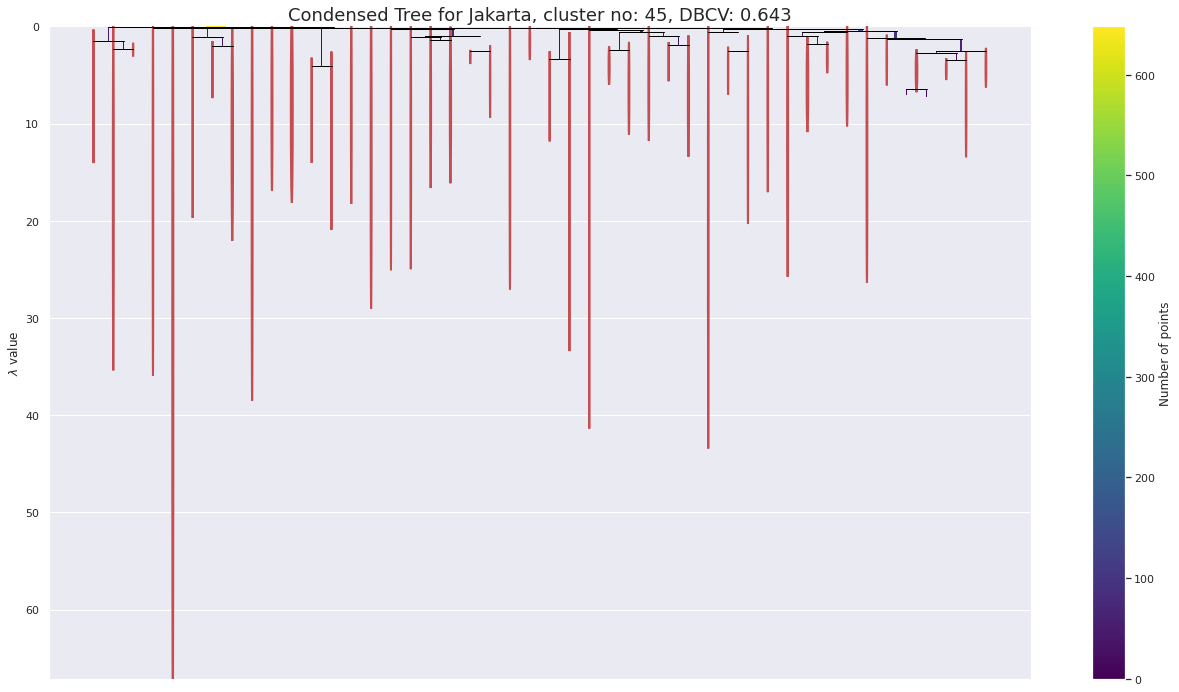

In [197]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for Jakarta, cluster no: 45, DBCV: 0.643", fontdict={"fontsize":18})
hdbscan_indo = hdbscan.HDBSCAN(min_cluster_size=7)
labels = hdbscan_indo.fit_predict(clusterable_embedding_indo)
hdbscan_indo.condensed_tree_.plot(select_clusters=True)
np.unique(labels)


### <br> Summary of general statistics for Jakarta clusters <br>
#### To assess the quality of produced clusters there a few metrics that can be used. Below I calculate the total number of clusters and total number of noice¶
#### which in other words mean that number of points that where not attached to any cluster. <br>

In [198]:
n_clusters_ = len(set(labels1[:])) - (1 if -1 in labels[:] else 0)
n_noise_ = list(labels[:]).count(-1)

#### <br>**DBCV - Density Based Clustering Validation** computes two values:

####   - the density within a cluster
####   - the density between clusters
#### High density within a cluster, and low density between clusters indicates good clustering assignments.<br>



In [199]:
hdbscan_score = DBCV(clusterable_embedding_indo, labels, dist_function=euclidean)

In [200]:
print("SUMMARY FOR JAKARTA")
print()
print("Estimation: number of clusters: %d" % n_clusters_)
print("Estimation: number of noise points: %d" % n_noise_)
print("Estimation: DBCV: %0.3f" % hdbscan_score)
print()

SUMMARY FOR JAKARTA

Estimation: number of clusters: 45
Estimation: number of noise points: 24
Estimation: DBCV: 0.643



In [201]:
idReduced["cluster"] = labels

In [202]:
idReduced

,hotel_id,hotel_lat,hotel_lon,hotel_distance,rooms_count,spa & wellness centre,disabled access,elevator / lift,business centre,air conditioned,free wifi,fitness room/gym,swimming pool,parking,cluster
0,52765,-6.255336,106.810825,6.180000,203,1,1,1,1,1,1,1,1,1,34
1,506274,-6.175420,106.729023,13.450000,1,0,0,1,0,1,1,1,1,1,19
2,506275,-6.208347,106.818008,3.020000,1,0,0,1,0,1,1,0,1,1,12
3,506278,-6.223455,106.784432,6.840000,1,0,0,1,0,1,1,1,1,1,15
4,506279,-6.162375,106.832172,5.650000,1,0,0,1,0,1,1,0,1,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,589802,-6.221410,106.815778,3.931276,214,0,0,0,0,0,1,0,1,1,34
644,589803,-6.127151,106.790440,3.931276,300,0,0,0,1,0,1,0,0,1,34
645,589804,-6.264619,106.782179,3.931276,311,0,0,0,1,0,1,0,1,1,34
646,589805,-6.187198,106.821936,3.931276,222,0,0,0,1,0,1,0,0,1,34


In [203]:
indonesia_train_umap_df["cluster"] = labels
indonesia_train_umap_df

,umap_1,umap_2,cluster
0,13.464391,-6.820889,34
1,20.050097,4.812988,19
2,7.241304,1.281886,12
3,20.432907,11.351249,15
4,0.409674,-0.974200,29
...,...,...,...
643,13.158555,-7.504176,34
644,13.334646,-7.307963,34
645,13.338256,-7.305331,34
646,13.343105,-7.298711,34


### Visualizing clusters for Jakarta

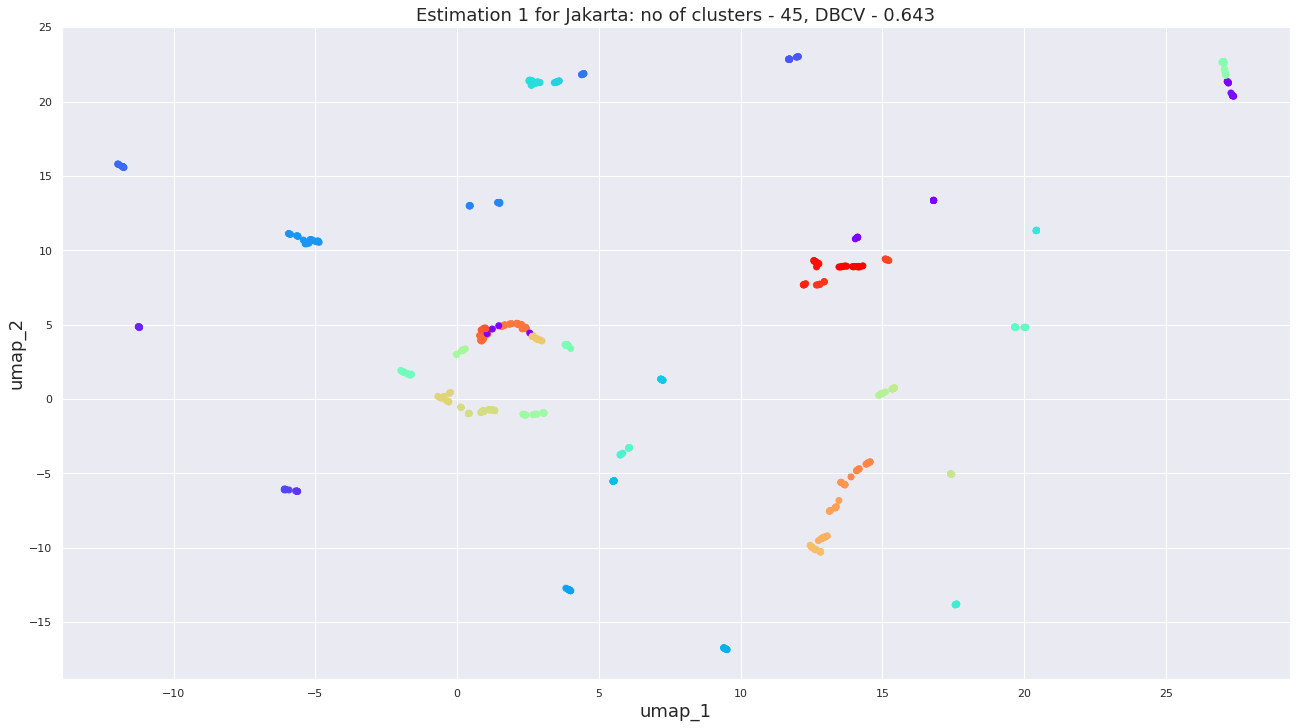

In [204]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=indonesia_train_umap_df, x="umap_1", y="umap_2", c= "cluster", cmap = "rainbow", label = "cluster")
plt.xlabel("umap_1",**axis_font)
plt.ylabel("umap_2",**axis_font)
plt.title("Estimation 1 for Jakarta: no of clusters - 45, DBCV - 0.643", fontdict={"fontsize":18})
plt.show()

In [205]:
# visualizing the plot in plotly
px.scatter(indonesia_train_umap_df, x="umap_1", y="umap_2", color = "cluster",  template = "plotly_dark", title = "Estimation for Jakarta: no of clusters - 45, DBCV - 0.643")

### 2. London

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

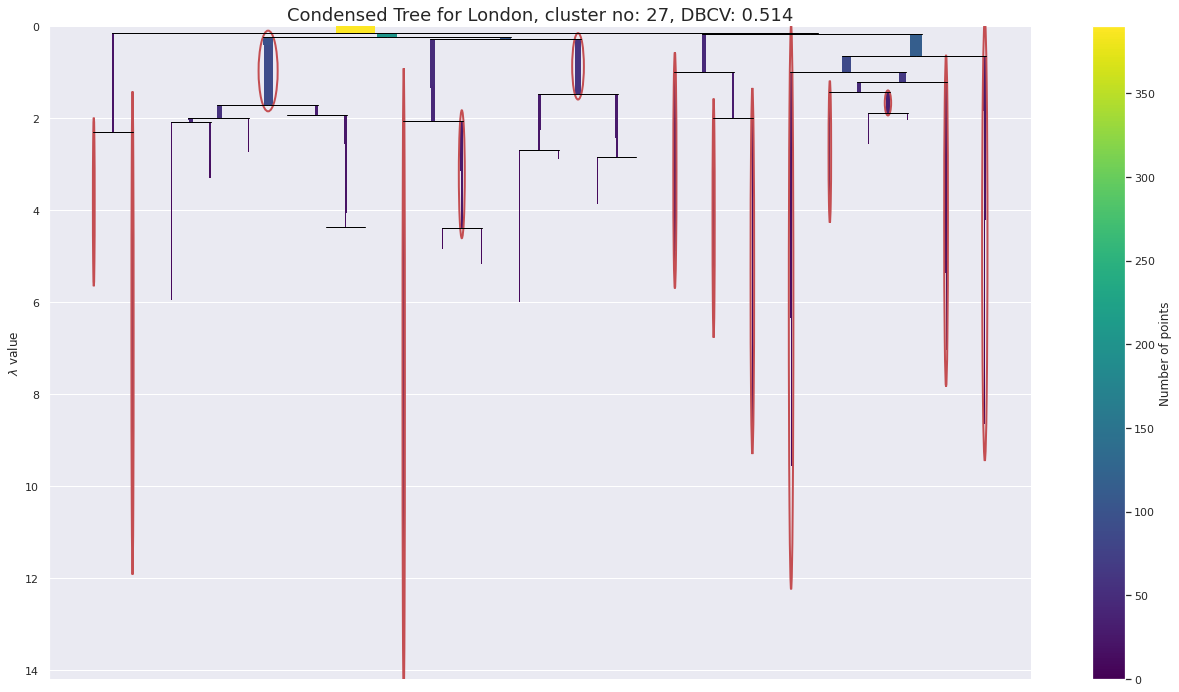

In [206]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for London, cluster no: 27, DBCV: 0.514", fontdict={"fontsize":18})
hdbscan_indo = hdbscan.HDBSCAN(min_cluster_size=7)
labels = hdbscan_indo.fit_predict(clusterable_embedding_gb)
hdbscan_indo.condensed_tree_.plot(select_clusters=True)
np.unique(labels)

### <br> Summary of general statistics for London clusters <br>

In [207]:
n_clusters_ = len(set(labels1[:])) - (1 if -1 in labels[:] else 0)
n_noise_ = list(labels[:]).count(-1)

In [208]:
hdbscan_score = DBCV(clusterable_embedding_gb, labels, dist_function=euclidean)

In [209]:
print("SUMARY FOR LONDON")
print()
print("Estimation: number of clusters: %d" % n_clusters_)
print("Estimation: number of noise points: %d" % n_noise_)
print("Estimation: DBCS: %0.3f" % hdbscan_score)
print()

SUMARY FOR LONDON

Estimation: number of clusters: 45
Estimation: number of noise points: 14
Estimation: DBCS: 0.514



In [210]:
gbReduced["cluster"] = labels

In [211]:
gbReduced

,hotel_id,hotel_lat,hotel_lon,hotel_distance,rooms_count,spa & wellness centre,elevator / lift,free wifi,swimming pool,pet friendly,business centre,disabled access,air conditioned,parking,cluster
0,5622,51.521259,-0.155856,3.120000,34,0,1,1,0,0,0,0,1,0,0
1,5630,51.512071,-0.185206,4.300000,45,0,1,1,0,0,0,0,0,0,6
2,5640,51.507706,-0.147138,1.670000,106,0,1,1,0,1,1,0,0,1,-1
3,5671,51.490098,-0.138130,1.390000,72,0,1,1,0,0,0,0,1,0,0
4,5681,51.496872,-0.167604,2.890000,28,0,1,1,0,1,1,0,0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,589981,51.508232,0.043758,6.915566,225,0,0,1,0,0,0,0,0,1,2
386,590977,51.516015,-0.118570,1.840000,0,0,1,1,0,1,1,0,1,1,11
387,592390,51.543948,-0.152331,5.200000,1,0,0,1,0,1,0,0,0,0,12
388,592405,51.511208,-0.119345,1.320000,0,0,0,1,0,0,0,1,0,0,10


In [212]:
gb_train_umap_df["cluster"] = labels
gb_train_umap_df

,umap_1,umap_2,cluster
0,5.913266,-3.417651,0
1,-5.454654,4.895547,6
2,-1.154549,15.071952,-1
3,5.864837,-3.598312,0
4,-1.186301,15.103143,11
...,...,...,...
385,4.451161,4.626297,2
386,-1.186822,15.104916,11
387,-0.902747,12.980925,12
388,1.693052,15.486526,10


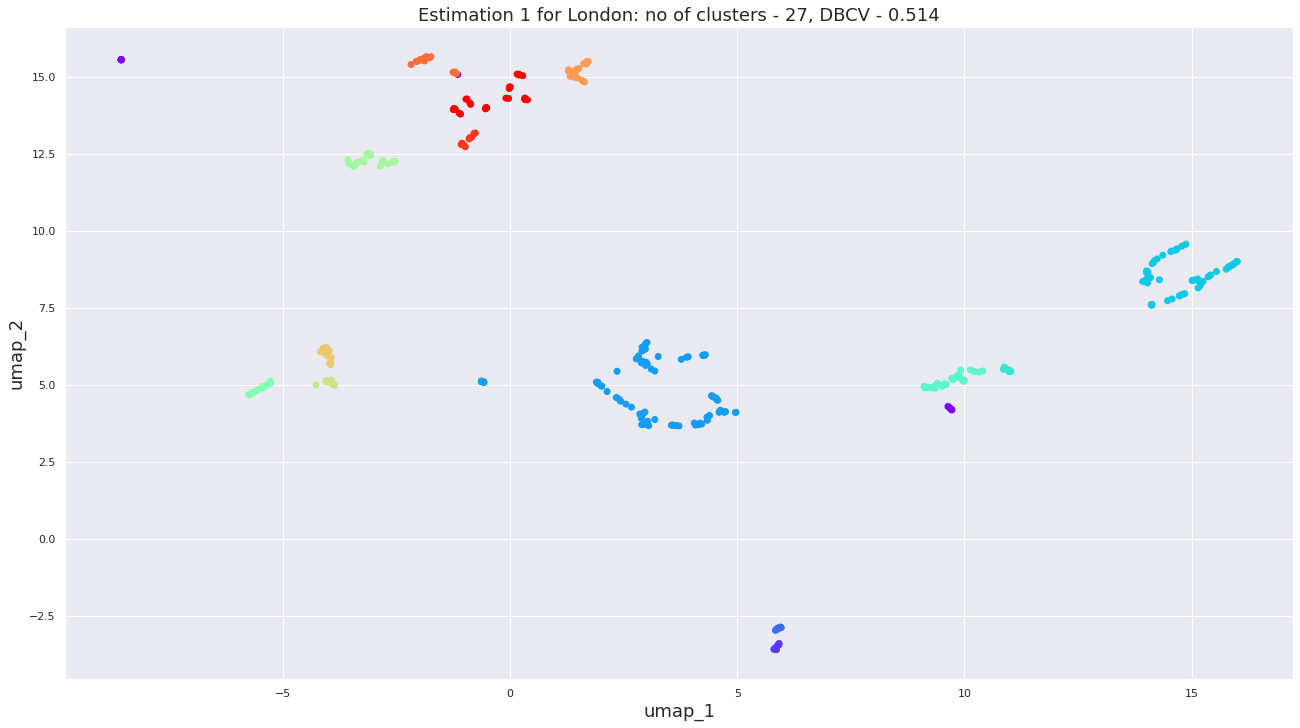

In [213]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=gb_train_umap_df, x="umap_1", y="umap_2", c= "cluster", cmap = "rainbow", label = "cluster")
plt.xlabel("umap_1",**axis_font)
plt.ylabel("umap_2",**axis_font)
plt.title("Estimation 1 for London: no of clusters - 27, DBCV - 0.514", fontdict={"fontsize":18})
plt.show()

In [214]:
#visualizing data also with plotly express
import plotly.express as px
px.scatter(gb_train_umap_df, x="umap_1", y="umap_2", color = "cluster",  template = "plotly_dark", title = "Estimation for London no of clusters - 27, DBCV - 0.514")

## <br> Concusions:<br>
#### 1. HDBSCAN analysis for these 2 types of datasets with UMAP algorythm as a dimention reduction algorythm created 40 clusters for Jakarta where different hotel types were 12, 31/15 for London where different hotel types were 18;
#### 2. Doing the analysis for mixed data is challenging that is why in most ocasions I was removing categorical data - that is why I do not processed together this time as the cities ID are large numbers which could be wrongly interpreted by Standard Scaler <br>

In [215]:
with pd.ExcelWriter("Downloads/hdbscanUMAPsamples.xlsx") as writer:
    idReduced.to_excel(writer, sheet_name="Jakarta")
    gbReduced.to_excel(writer, sheet_name="London")